# EDA (Exploratory Data Analysis)
<br>
In this notebook you will find an analysis that examines the dataset we ensembled from our previous steps. It provides a visualization of the distribution of classes, as well as the main characteristics between each audio like duration. Visualizations include various plots such as barplots, histograms, and boxplots. Then for audio specific visuals we used waveplots to plot the audio signals, and different representations of the audios like MFCCs and Linear Power Spectrograms. 

We also found it necessary to reformat the dataset to aid us in future steps like augmentation and modeling. Reformatting including audio length clipping and then zero padding. Zero padding was necessary because we have audios less than the mean length across the entire dataset, which is where we clipped. No other reformatting was essential because we were able to keep it consistent by ensembling it ourselves.

### Approach 

- **Exploratory data analysis:**
    - Visualization of each class audio waveform
    - Visualization of each class audio spectrogram
    - Visualization of each class audio MFCC
    - Class distribution of dataset
        - Acquired differences by percentages 
    - Counts of each audios properties (sample rate, bit depth, # of channels, duration and format)
        - Collected mean and standard deviation of durations
        - Min and max sample rate
   

<br>
See conclusion at bottom for more details and next steps.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import gc
import librosa.display
import librosa
import glob
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import soundpy as sp
import IPython.display as ipd
from pathlib import Path
from pydub import AudioSegment

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('notebook')
sns.set_style("ticks")

In [3]:
# Helper function for organizing classes and importing .wavs

def ignore_case(pattern):
    return ''.join(
        (f'[{c.lower()}{c.upper()}]' if c.isalpha() else c for c in pattern))

def multi_glob(patterns):
    for path, pattern in patterns:
        yield from glob.iglob(os.path.join(path, ignore_case(pattern)))

In [4]:
# Get percentage difference between number of files

def get_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

In [5]:
# Get information on full dataset and classes

def get_wav_info(file_list):
    
    all_wav_info = dict()
    for f in file_list:
        info_dict = sp.builtin.dataset_logger(f, recursive=True);
        all_wav_info.update(info_dict)
        
    all_wav_info = pd.DataFrame(all_wav_info).T
    all_wav_info.head()
    
    return all_wav_info

In [8]:
# Designate labels for each filename within folder classes

labels = dict([('bear', 0), ('bull', 1), ('neut', 2)])
paths = list(
    multi_glob((("C:/Users/aranc/Desktop/GCP_Notebooks/capstone-project-3/data/bear_label_wavs/", "*.wav"),
                ("C:/Users/aranc/Desktop/GCP_Notebooks/capstone-project-3/data/neut_label_wavs/", "*.wav"),
                ("C:/Users/aranc/Desktop/GCP_Notebooks/capstone-project-3/data/bull_label_wavs/", "*.wav"))))  # Import filenames

In [9]:
# Labeled dictionary for each class

label_wavs_dict = sp.datasets.create_encodedlabel2audio_dict(labels, paths)

In [10]:
# Dictionary to dataframe, organized by class label

d = pd.DataFrame({"files":label_wavs_dict[0]})
d['label_encode'] = labels['bear'] 
d = d.append(pd.DataFrame({"files":label_wavs_dict[2], "label_encode":labels['neut']}))
d = d.append(pd.DataFrame({"files":label_wavs_dict[1], "label_encode":labels['bull']}))
d = d.reset_index()
d = d.drop('index', 1)

In [11]:
labels = {'bear','bull','neut'}
label2int, int2label = sp.datasets.create_dicts_labelsencoded(labels) # Function to convert text to number labels

In [12]:
d = d.replace({"label_encode": int2label})
d.head()

files label_encode
0  C:/Users/aranc/Desktop/GCP_Notebooks/capstone-...         bear
1  C:/Users/aranc/Desktop/GCP_Notebooks/capstone-...         bear
2  C:/Users/aranc/Desktop/GCP_Notebooks/capstone-...         bear
3  C:/Users/aranc/Desktop/GCP_Notebooks/capstone-...         bear
4  C:/Users/aranc/Desktop/GCP_Notebooks/capstone-...         bear

In [13]:
# Group files by label

label_group = d.groupby('label_encode')
bear_label = label_group.get_group('bear')
bull_label = label_group.get_group('bull')
neut_label = label_group.get_group('neut')

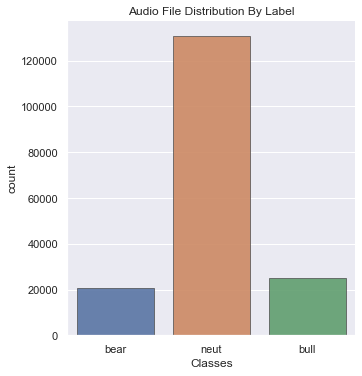

Total bearish audios (0): 20514 
Total bullish audios (1): 24999 
Total neutral audios (2): 130920 
 
Neutral audios make up 74.204% of the dataset 
Bearish audios make up 11.627% of the dataset 
Bullish audios make up 14.169% of the dataset


In [14]:
# Plot and get difference between the distribution of classes

%matplotlib inline

sns.set_theme(style="darkgrid")

sns.catplot(data=d,
            x="label_encode",
            kind='count',
            palette="deep",
            edgecolor=".3",
            linewidth=.8,
            alpha=0.9)

plt.title("Audio File Distribution By Label")
plt.xlabel("Classes")
plt.show()

b = get_change(len(bear_label), len(d))
b = 100 - b
b2 = get_change(len(bull_label), len(d))
b2 = 100 - b2
n = get_change(len(neut_label), len(d))
n = 100 - n

print("Total bearish audios (0):", len(bear_label), "\n"
      "Total bullish audios (1):", len(bull_label), "\n"
      "Total neutral audios (2):", len(neut_label), "\n",
      "\nNeutral audios make up", str(round(n, 3)) + "%", "of the dataset", "\n"
      "Bearish audios make up", str(round(b, 3)) + "%", "of the dataset", "\n"
      "Bullish audios make up", str(round(b2, 3)) + "%", "of the dataset")

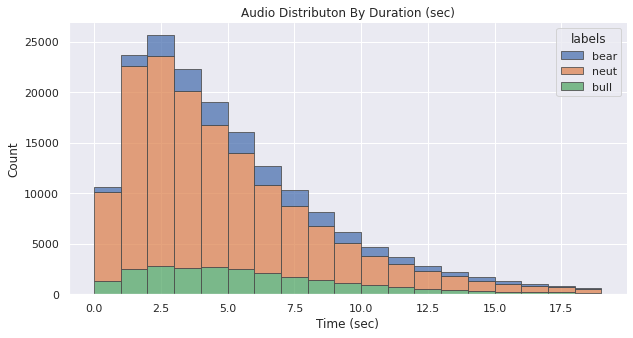

In [14]:
# Plot distribution of class by durations 

%matplotlib inline

sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(wave_info_df,
             x="dur_sec",
             hue="labels",
             multiple="stack",
             palette="deep",
             edgecolor=".3",
             linewidth=.8,
             bins=range(0, 20))

plt.title("Audio Distributon By Duration (sec)")
plt.xlabel("Time (sec)")
plt.show()

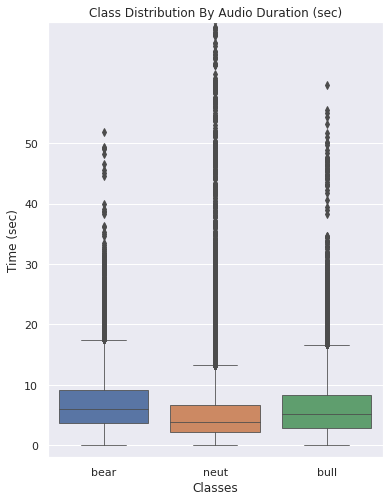

In [15]:
# Box plot to visualize how much larger the neutral class is than bearish and bullish

plt.figure(figsize=(6, 8))

sns.boxplot(x='labels',
            y='dur_sec',
            data=wave_info_df,
            palette="deep",
            linewidth=.8)

plt.title("Class Distribution By Audio Duration (sec)")
plt.xlabel("Classes")
plt.ylabel("Time (sec)")
plt.yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-2, 70)
plt.show()

In [16]:
# Get dataset information for dataframe

data = formats = wave_info_df.format_type.unique()
bitDepth_type = wave_info_df.bitdepth.unique()
mean_duration = wave_info_df.dur_sec.mean()
standard_dev = wave_info_df.dur_sec.std()
min_sr = wave_info_df.sr.min()
max_sr = wave_info_df.sr.max()
n_channels = wave_info_df.num_channels.unique()

In [17]:
# Map properties to dataframe, find duration mean, std, min/max sample rate

info_data = pd.DataFrame({
    "Formats": [formats],
    "bitDepth_type": [bitDepth_type],
    "meanDuration": [mean_duration],
    "standardDeviation": [standard_dev],
    "minSampleRate": [min_sr],
    "maxSampleRate": [max_sr],
    "numChannels": [n_channels]
})

info_df = pd.DataFrame(info_data)
info_df

Formats bitDepth_type  meanDuration  standardDeviation  minSampleRate  \
0   [WAV]      [PCM_16]      5.590895           6.853982          16000   

   maxSampleRate numChannels  
0          16000         [1]

In [18]:
# Helper function to load audios

def load_audios(directory_path):
    
    sr = 16000
    loaded_audios = []
    for files in directory_path:
        f, sr = sp.loadsound(str(files), sr=sr)
        loaded_audios.append(f)
        
    return loaded_audios

In [19]:
wavs_raw = load_audios(wave_info_df["audio"]) # Load audios from dataframe
len(wavs_raw)

176433

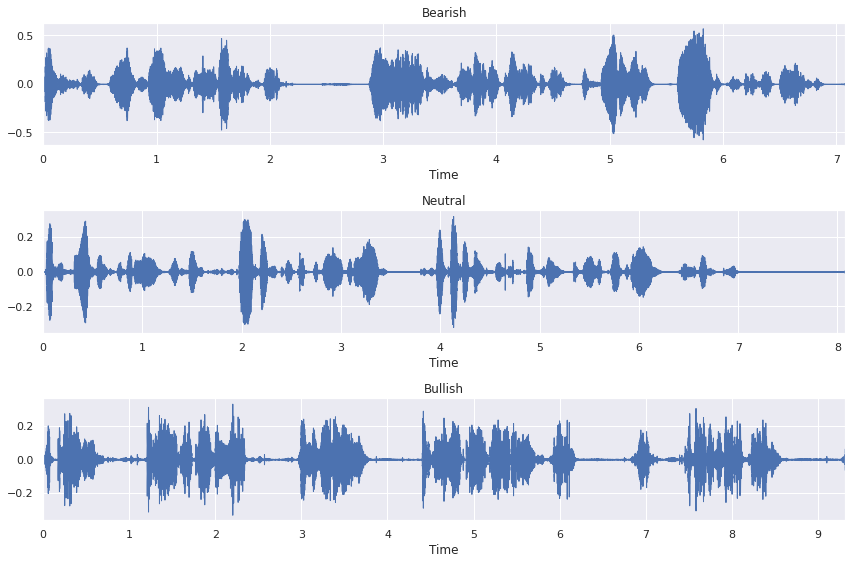

In [20]:
# Plot each class waveform

sr=16000
plt.figure(figsize=(12,8))

plt.subplot(3, 1, 1)
librosa.display.waveplot(wavs_raw[2], sr=sr)
plt.title('Bearish')

plt.subplot(3, 1, 2)
librosa.display.waveplot(wavs_raw[35002], sr=sr)
plt.title('Neutral')

plt.subplot(3, 1, 3)
librosa.display.waveplot(wavs_raw[108360], sr=sr)
plt.title('Bullish')

plt.tight_layout()

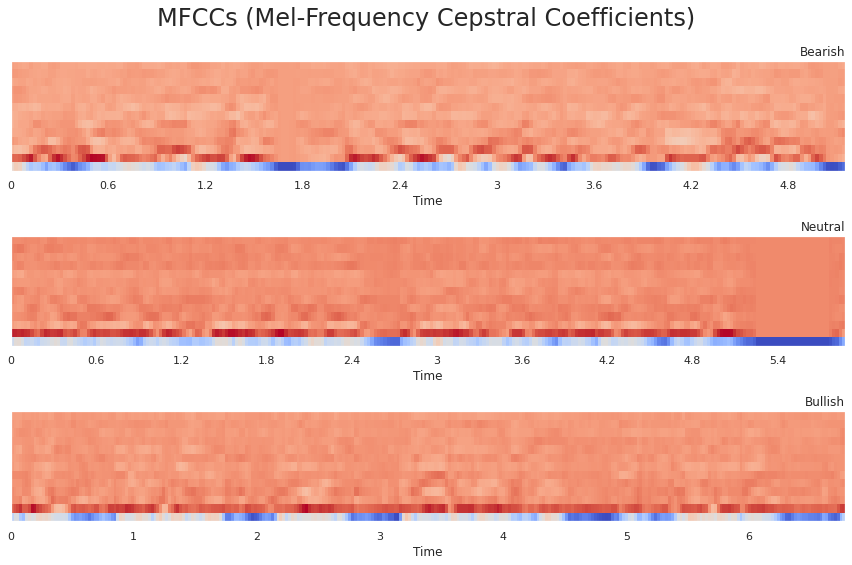

In [41]:
# Get and plot each class MFCC 

bearish_mfcc = librosa.feature.mfcc(wavs_raw[2], sr=sr, n_mfcc=13)
neutral_mfcc = librosa.feature.mfcc(wavs_raw[35002], sr=sr, n_mfcc=13)
bullish_mfcc = librosa.feature.mfcc(wavs_raw[108360], sr=sr, n_mfcc=13)

plt.figure(figsize=(12,8))
plt.suptitle('MFCCs (Mel-Frequency Cepstral Coefficients)', fontsize=24)

plt.subplot(3, 1, 1)
librosa.display.specshow(bearish_mfcc, x_axis='time')
plt.title('Bearish', loc='right')

plt.subplot(3, 1, 2)
librosa.display.specshow(neutral_mfcc, x_axis='time')
plt.title('Neutral', loc='right')

plt.subplot(3, 1, 3)
librosa.display.specshow(bullish_mfcc, x_axis='time')
plt.title('Bullish', loc='right')

plt.tight_layout()

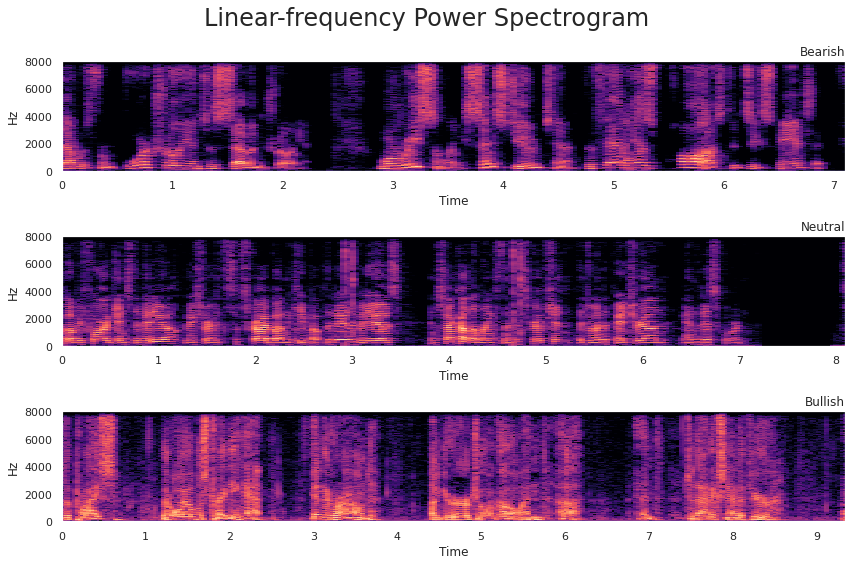

In [42]:
# Get and plot each class linear-freq power spectrogram

bearish_stft_powspec = librosa.amplitude_to_db(np.abs(librosa.stft(wavs_raw[2])), ref=np.max)
neutral_stft_powspec = librosa.amplitude_to_db(np.abs(librosa.stft(wavs_raw[35002])), ref=np.max)
bullish_stft_powspec = librosa.amplitude_to_db(np.abs(librosa.stft(wavs_raw[108360])), ref=np.max)

plt.figure(figsize=(12,8))
plt.suptitle('Linear-frequency Power Spectrogram', fontsize=24)

plt.subplot(3, 1, 1)
librosa.display.specshow(bearish_stft_powspec, y_axis='linear', x_axis='time', sr=sr)
plt.title('Bearish', loc='right')

plt.subplot(3, 1, 2)
librosa.display.specshow(neutral_stft_powspec, y_axis='linear', x_axis='time', sr=sr)
plt.title('Neutral', loc='right')

plt.subplot(3, 1, 3)
librosa.display.specshow(bullish_stft_powspec, y_axis='linear', x_axis='time', sr=sr)
plt.title('Bullish', loc='right')

plt.tight_layout()

## Reformat Dataset
<br>
Because our original dataset contained audio files that have a length of zero, we need to reformat their durations so librosa is able to load and read each audio file. By zero-padding each individual audio by 8.0 seconds, it will allow us to extract the features of all audios, while not altering the original distribution or signal itself.

In [95]:
# Reformat dataset w/ parameters

for f in wav_f:
    info_dict = sp.builtin.dataset_formatter(
        f,
        recursive=True,  
        format='WAV',
        bitdepth=16,  
        sr=16000,  
        mono=True,  
        dur_sec=8,  
        zeropad=True,  
        new_dir=
        './capstone-project-3/data/', 
        overwrite=True 
    ) 

In [91]:
# Set new designated directories

bear_wavs = glob.glob("./capstone-project-3/data/bear_label_wavs/", recursive=True)
neut_wavs = glob.glob("./capstone-project-3/data/neut_label_wavs/", recursive=True)
bull_wavs = glob.glob("./capstone-project-3/data/bull_label_wavs/", recursive=True)

wav_f = bear_wavs + neut_wavs + bull_wavs
wav_f

['./capstone-project-3/data/bear_label_wavs/',
 './capstone-project-3/data/neut_label_wavs/',
 './capstone-project-3/data/bull_label_wavs/']

In [97]:
# Create dataframe and visualize new formated audio properties

wave_info_df2 = get_wav_info(wav_f)

encode_labels = list(d.label_encode)
wave_info_df2['labels'] = encode_labels
wave_info_df2.head()

100% through logging audio file details

audio  \
capstone-project-3/data/bear_label_wavs/BEAR_90...  capstone-project-3/data/bear_label_wavs/BEAR_9...   
capstone-project-3/data/bear_label_wavs/BEAR_46...  capstone-project-3/data/bear_label_wavs/BEAR_4...   
capstone-project-3/data/bear_label_wavs/BEAR_70...  capstone-project-3/data/bear_label_wavs/BEAR_7...   
capstone-project-3/data/bear_label_wavs/BEAR_58...  capstone-project-3/data/bear_label_wavs/BEAR_5...   
capstone-project-3/data/bear_label_wavs/BEAR_15...  capstone-project-3/data/bear_label_wavs/BEAR_1...   

                                                       sr num_channels  \
capstone-project-3/data/bear_label_wavs/BEAR_90...  16000            1   
capstone-project-3/data/bear_label_wavs/BEAR_46...  16000            1   
capstone-project-3/data/bear_label_wavs/BEAR_70...  16000            1   
capstone-project-3/data/bear_label_wavs/BEAR_58...  16000            1   
capstone-project-3/data/bear_label_wavs/BEAR_15...  16000            1   

                                                   dur_sec format_type  \
capstone-project-3/data/bear_label_wavs/BEAR_90...     8.0         WAV   
capstone-project-3/data/bear_label_wavs/BEAR_46...     8.0         WAV   
capstone-project-3/data/bear_label_wavs/BEAR_70...     8.0         WAV   
capstone-project-3/data/bear_label_wavs/BEAR_58...     8.0         WAV   
capstone-project-3/data/bear_label_wavs/BEAR_15...     8.0         WAV   

                                                   bitdepth labels  
capstone-project-3/data/bear_label_wavs/BEAR_90...   PCM_16   bear  
capstone-project-3/data/bear_label_wavs/BEAR_46...   PCM_16   bear  
capstone-project-3/data/bear_label_wavs/BEAR_70...   PCM_16   bear  
capstone-project-3/data/bear_label_wavs/BEAR_58...   PCM_16   bear  
capstone-project-3/data/bear_label_wavs/BEAR_15...   PCM_16   bear

In [98]:
wave_info_df2.to_csv("./capstone-project-3/new_data/master_audio_df.csv", index=False) # save final dataset

In [ ]:
#pd.read_csv("./capstone-project-3/data/master_audio_df.csv")

<AxesSubplot:title={'center':'Sample Rate Counts'}, xlabel='sr'>

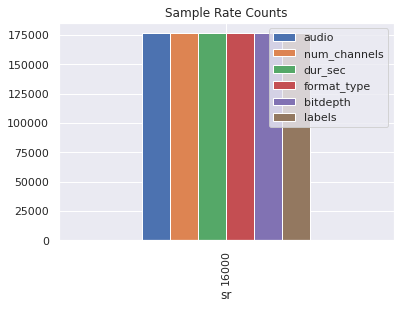

In [99]:
# Plot counts of audio properties, see if equal

wave_info_df2.groupby('sr').count().plot(kind = 'bar', title = 'Sample Rate Counts') 

In [100]:
# Collect unique characteristics of reformatted dataset

data = formats = wave_info_df2.format_type.unique()
bitDepth_type = wave_info_df2.bitdepth.unique()
mean_duration = wave_info_df2.dur_sec.mean()
standard_dev = wave_info_df2.dur_sec.std()
min_sr = wave_info_df2.sr.min()
max_sr = wave_info_df2.sr.max()
n_channels = wave_info_df2.num_channels.unique()

In [101]:
# Map to dataframe

info_data = pd.DataFrame({
    "Formats": [formats],
    "bitDepth_type": [bitDepth_type],
    "meanDuration": [mean_duration],
    "standardDeviation": [standard_dev],
    "minSampleRate": [min_sr],
    "maxSampleRate": [max_sr],
    "numChannels": [n_channels]
})

info_df = pd.DataFrame(info_data)
info_df

Formats bitDepth_type  meanDuration  standardDeviation  minSampleRate  \
0   [WAV]      [PCM_16]           8.0                0.0          16000   

   maxSampleRate numChannels  
0          16000         [1]

In [102]:
def load_audios(directory_path):
    
    sr = 16000
    loaded_audios = []
    for files in directory_path:
        f, sr = sp.loadsound(str(files), sr=sr)
        loaded_audios.append(f)
        
    return loaded_audios

In [103]:
wavs_formatted = load_audios(wave_info_df2["audio"]) # needed to reload .wavs
len(wavs_formatted)

176433

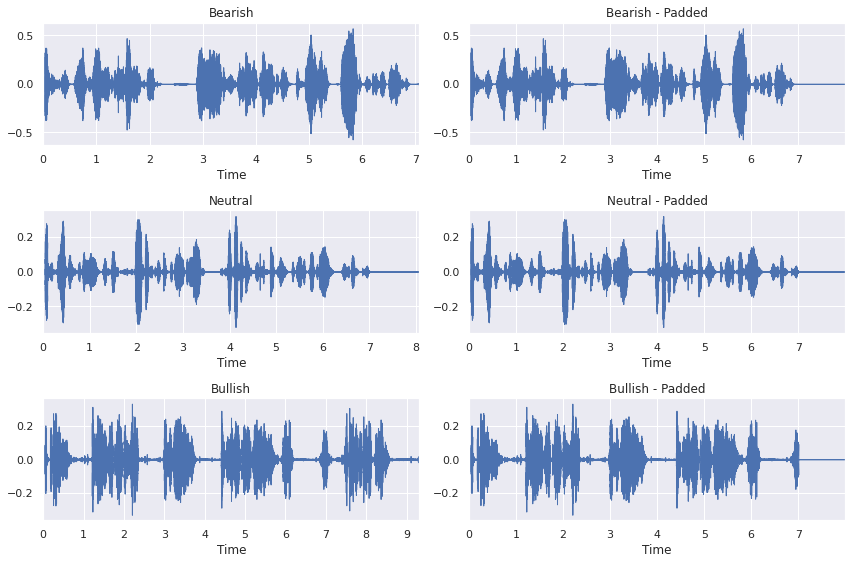

In [106]:
# Plot and compare new waveforms (padded) to original (unpadded)

sr=16000
plt.figure(figsize=(12,8))

#-----Bearish-------
plt.subplot(3, 2, 1)
librosa.display.waveplot(wavs_raw[2], sr=sr)
plt.title('Bearish')
plt.subplot(3, 2, 2)
librosa.display.waveplot(wavs_formatted[2], sr=sr)
plt.title('Bearish - Padded')

#-----Neutral------
plt.subplot(3, 2, 3)
librosa.display.waveplot(wavs_raw[35002], sr=sr)
plt.title('Neutral')
plt.subplot(3, 2, 4)
librosa.display.waveplot(wavs_formatted[35002], sr=sr)
plt.title('Neutral - Padded')

#-----Bullish------
plt.subplot(3, 2, 5)
librosa.display.waveplot(wavs_raw[108360], sr=sr)
plt.title('Bullish')
plt.subplot(3, 2, 6)
librosa.display.waveplot(wavs_formatted[108360], sr=sr)
plt.title('Bullish - Padded')

plt.tight_layout()

# Conclusion
<br>

In this notebook we explored the data thoroughly by first examining the datasets distribution of classes. This lead us to realize that it will be necessary in the next steps to augment the bearish and bullish audios at least at least 6 times all together to make up for the lack of data in comparison to the neutral audios. To prep for that we reformatted the dataset by transforming the audios to have an equal duration by zero padding them up to 8.0 sec. Reformatting was necessary because a fair amount of "neutral" audios contained empty frames less than 0 which is unreadable by librosa. We chose 8.0 duration by finding the mean length of the audios (5.6 sec) and the standard deviation (6.9 sec), since the variance of the lengths differed by about 7 seconds we added an extra second to make sure the bulk of speech was contained in the reformatted audios even in the longer audios. 

- Total bearish audios (0): 20514 
- Total bullish audios (1): 24999 
- Total neutral audios (2): 130920 

Neutral audios make up 74.2% of our entire dataset which is significantly greater than both bearish and bullish audios. Total amount of bearish audios make up 11.6% of the dataset while bullish audios make up 14.1% of it. 

We then explored various audios potential features by plotting their waveforms, MFCCs, and power spectrograms. A simple inference one can make by visually examining the plots is that the bullish audios usually contained more frequent and longer drawn out pauses of silence. Further work in examining this potential lead or difference might aid in extracted specified features that can improve future models. 

Lastly, we plotted the comparison between original audios vs padded audios to demonstrate the action visually. We also plotted the counts of all unique features of all the audios, revealing to us that our newly reformatted dataset contains audios that have the same sample rate, duration, bit depth, and number of channels. Because our dataset now contains an equal number of properties, aside from it's overall distribution it is now ready to be used in the next steps. Those next steps being; train/test split, augmentation/feature extraction and then lastly modeling. 